**Author:** *Johannes Peter Knoll*

# Introduction

This notebook demonstrates all functionalities this project offers:
- preprocess data (unify data, split training data into training- and validation- pids)
- train neural network
- predict sleep stages of Validation data and evaluate neural network performance
- predict sleep stages of non-training and non-validation data

It is basically the commented version of the file: "main.py".

In [2]:
# The autoreload extension allows you to tweak the code in the imported modules
# and rerun cells to reflect the changes.
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [1]:
# LOCAL IMPORTS
from main import *
from plot_helper import *

# IMPORTS
import h5py # type: ignore
import random

# Training Data

We essentially want to map RRI (and MAD) data to sleep stages. So we need datasets providing exactly this.
For training our model, we used the following:
- SHHS: provides RRI and sleep stage
- GIF: provides RRI, MAD and sleep stage

## SHHS Dataset

The [Sleep Heart Health Study (SHHS)](https://sleepdata.org/datasets/shhs) is a multi-center cohort study implemented by the National Heart Lung & Blood Institute to determine the cardiovascular and other consequences of sleep-disordered breathing.

### Download Dataset

In [ ]:
# !wget "https://onedrive.live.com/download?cid=45D5A10F94E33861&resid=45D5A10F94E33861%21248707&authkey=AKRa5kb3XFj4G-o" -O shhs_dataset.h5

### Accessing Dataset

In [ ]:
#path_to_shhs_dataset = "../Training_Data/SHHS_dataset.h5"
path_to_shhs_dataset = "Raw_Data/SHHS_dataset.h5"

shhs_dataset = h5py.File(path_to_shhs_dataset, 'r')

## GIF Dataset

Unfortunately, the GIF data is not publicly available.

# Project Configuration

Project Configuration includes [setting file paths](#setting-file-paths) and [adjusting parameters](#adjusting-parameters).

Preprocessing data and training the neural network can be controlled using various parameters. To ensure that
for later predictions we use the same parameters to set up the neural network and preprocess our data we will
save those as dictionary to a pickle file, which will be accessed at every step.

## Default Parameters

It is highly UNRECOMMENDED to change the following default parameters, especially if you aim to adjust a few 
parameters.

In the following section ['Creating Project Configuration'](#creating-project-configuration) we will see the 
recommended way of adjusting parameters.

### Parameters for 'SleepDataManager' class

The `SleepDataManager` class and all data processing functions are thoroughly explained in the jupyter 
notebook: `Processing_Demo`. However, below is a short summary of the important basics you need to for this
project:

This class resaves your training data to a seperate pickle file and ensures that the data is uniform and can
be accessed and passed to the neural network in a memory saving way. During the saving process it might perform
the following actions:
- scale number of datapoints in signal so that the current signals sampling frequency matches the uniform 
    database signal frequency
- alter sleep labels
- remove RRI and/or MAD outliers
- split signal into multiple signals if signal is longer than the uniform maximum signal length: 
    'signal_length_seconds'

All other functionalities of this class will be explained during this project when necessary.

See `SleepDataManager` class in `dataset_processing.py`

In [ ]:
sleep_data_manager_parameters = {
    "RRI_frequency": 4,
    "MAD_frequency": 1,
    "SLP_frequency": 1/30,
    "RRI_inlier_interval": [0.3, 2],
    "MAD_inlier_interval": [None, None],
    "sleep_stage_label": {"wake": 0, "LS": 1, "DS": 2, "REM": 3, "artifect": 0},
    "signal_length_seconds": 36000,
    "wanted_shift_length_seconds": 5400,
    "absolute_shift_deviation_seconds": 1800,
}

### Splitting data into pids

Splitting our data into training-, validation- (and test-) pids can be performed using the `SleepDataManager` 
class.

See: `separate_train_test_validation` function of `SleepDataManager` class in `dataset_processing.py`

In [ ]:
split_data_parameters = {
    "train_size": 0.8,
    "validation_size": 0.2,
    "test_size": None,
    "random_state": None,
    "shuffle": True
}

### Parameters for 'CustomSleepDataset' class

Custom Dataset class for our Sleep Stage Data. The class is used to load data from a file 
(using `SleepDataManager` class) and prepare it for training the neural network.

The whole project including this [class](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
were created in analogy to the [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/basics/). 
Knowing this tutorial is not necessary for using this project, but highly recommended should you be interested
in understanding and editing the code.

See: `CustomSleepDataset` class in `neural_network_model.py`

In [ ]:
dataset_class_transform_parameters = {
    "transform": ToTensor(), 
    "target_transform": None,
}

### Reshape signals to overlapping windows

Reshape a signal with shape (n <= nn_signal_duration_seconds * target_frequency) to 
(number_windows, window_size), where windows overlap by 'overlap_seconds' and adjust the signal to the neural 
network's requirements.

This will be performed when accessing the data using 'CustomSleepDataset' class.

See: `reshape_signal_to_overlapping_windows` function in `dataset_processing.py`

In [ ]:
window_reshape_parameters = {
    "nn_signal_duration_seconds": sleep_data_manager_parameters["signal_length_seconds"],
    "number_windows": 1197,
    "window_duration_seconds": 120,
    "overlap_seconds": 90,
    "priority_order": [3, 2, 1, 0],
    "pad_feature_with": 0,
    "pad_target_with": 0
}
sleep_data_manager_parameters["SLP_expected_predicted_frequency"] = 1/window_reshape_parameters["window_duration_seconds"]

### Normalization

Normalize the signal into range: (normalization_min, normalization_max) using the unity based normalization 
method.

This will be performed when accessing the data using `CustomSleepDataset` class.

See: `unity_based_normalization` function in `dataset_processing.py`

In [ ]:
signal_normalization_parameters = {
    "normalize_rri": False,
    "normalize_mad": False,
    "normalization_max": 1,
    "normalization_min": 0,
    "normalization_mode": "global"
}

### Neural Network Architecture

Parameters affecting the neural network architecture.

See `SleepStageModel` or `YaoModel` class in `neural_network_model.py`

In [ ]:
neural_network_model_parameters = {
    "neural_network_model": SleepStageModel,
    "number_sleep_stages": 4,
    "datapoints_per_rri_window": int(sleep_data_manager_parameters["RRI_frequency"] * window_reshape_parameters["window_duration_seconds"]),
    "datapoints_per_mad_window": int(sleep_data_manager_parameters["MAD_frequency"] * window_reshape_parameters["window_duration_seconds"]),
    "windows_per_signal": window_reshape_parameters["number_windows"],
    "number_window_learning_features": 128,
    "rri_convolutional_channels": [1, 8, 16, 32, 64],
    "mad_convolutional_channels": [1, 8, 16, 32, 64],
    "window_learning_dilations": [2, 4, 8, 16, 32],
}

### Neural Network Training Hyperparameters

Hyperparameters used when training the neural network. 

These are the only ones that will not be saved to the project configuration file, because they might differ 
based on what data is currently used for training.

See `main_model_training` function in `main.py`

In [ ]:
neural_network_hyperparameters_shhs = {
    "batch_size": 8,
    "number_epochs": 40,
    "lr_scheduler_parameters": {
        "number_updates_to_max_lr": 10,
        "start_learning_rate": 2.5 * 1e-5,
        "max_learning_rate": 1 * 1e-4,
        "end_learning_rate": 5 * 1e-5
    }
}

neural_network_hyperparameters_gif = {
    "batch_size": 8,
    "number_epochs": 100,
    "lr_scheduler_parameters": {
        "number_updates_to_max_lr": 25,
        "start_learning_rate": 2.5 * 1e-5,
        "max_learning_rate": 1 * 1e-4,
        "end_learning_rate": 1 * 1e-5
    }
}

## Setting File Paths

During this project, you will likely create a lot of files. Most of them are assigned an intuitive name in 
`main.py`. It is recommended to leave them be or changing them once before creating your first project.

Now you only need to set the directory where you want to store your files or from which you want to access the
trained model for making predictions:

In [6]:
processed_shhs_path = "Processed_Data/shhs_data.pkl"
processed_gif_path = "Processed_Data/gif_data.pkl"

# Create directory to store configurations and results
model_directory_path = "Neural_Network/"
create_directories_along_path(model_directory_path)

## Creating Project Configuration

We will now create a dictionary that holds all parameters introduced in the previous section 
['Default Parameters'](#default-parameters).

The current default parameters correspond to the idea of: overlapping windows, artifact = wake stage

In [ ]:
project_configuration = dict()
project_configuration.update(sleep_data_manager_parameters)
project_configuration.update(window_reshape_parameters)
project_configuration.update(signal_normalization_parameters)
project_configuration.update(split_data_parameters)
project_configuration.update(dataset_class_transform_parameters)
project_configuration.update(neural_network_model_parameters)

### Adjusting Parameters

If you aim to test one of the additional ideas below, just run the corresponding cell. 
DO NOT RUN BOTH CELLS! 

To prevent accidentally runnning one of the cells, they were set up to raise an error. This line needs to be
removed if you aim to adjust it, obviously.

This would also be the ideal place to create your own paragraph with your desired adjustments!

Additional Idea: non-overlapping windows, artifect = wake stage:

In [ ]:
raise ValueError("This Error was intentionally placed here to prevent the user from running this cell" +
                    " accidentally. Uncomment this line only if you know what you are doing.")

project_configuration["overlap_seconds"] = 0
project_configuration["number_windows"] = 300
project_configuration["windows_per_signal"] = 300

Additional Idea: overlapping windows, artifect is a unique stage

In [ ]:
raise ValueError("This Error was intentionally placed here to prevent the user from running this cell" +
                    " accidentally. Uncomment this line only if you know what you are doing.")

project_configuration["sleep_stage_label"] = {"wake": 1, "LS": 2, "DS": 3, "REM": 4, "artifect": 0}
project_configuration["priority_order"] = [4, 3, 2, 1, 0]
project_configuration["number_sleep_stages"] = 5

Play around:

In [ ]:
raise ValueError("This Error was intentionally placed here to prevent the user from running this cell" +
                    " accidentally. Uncomment this line only if you know what you are doing.")

project_configuration["..."] = "..."

### Checking and Saving Project Configuration

In [ ]:
check_project_configuration(project_configuration)

if os.path.isfile(model_directory_path + project_configuration_file):
    os.remove(model_directory_path + project_configuration_file)
save_to_pickle(project_configuration, model_directory_path + project_configuration_file)

del project_configuration

# Preprocess Training Data

## Expanding on `SleepDataManager` class

As mentioned above: During the saving process, the `SleepDataManager` class makes sure that the data is 
uniform and might perform the following actions:
- Scale number of datapoints in signal if sampling frequency does not match
- Alter sleep stage labels if they do not refer to the same context
- Remove outliers from RRI and/or MAD data
- Split datapoint into multiple ones, if signal duration is too long to be processable by the neural network

To do all of this, we need to provide more information than just the signal itself:

In [ ]:
# Saveable Datapoint:
"""
{
    "ID": str,                  # always required
    "RRI": np.ndarray,
    "MAD": np.ndarray,
    "SLP": np.ndarray,
    "RRI_frequency": int,       # required if RRI signal is provided
    "MAD_frequency": int,       # required if MAD signal is provided
    "SLP_frequency": int,       # required if SLP signal is provided
    "sleep_stage_label": list   # required if SLP signal is provided
}
"""

Most of the keys are save explaining, except for the last one ('sleep_stage_label'):

Different sources might use different numbers to label the sleep stages. The last key is used to ensure
this projection is uniform. Here is a possible problem, where 'SSM stage' (SleepStageModel stage) refers to 
the projection used for training the neural network: 

|number|SHHS stage|GIF stage| SSM stage         |
|------|----------|---------|-------------------|
|  0   | wake     | wake    | wake & artifact   |
|  1   | N1       | N1      | LS                |
|  2   | N2       | N2      | DS                |
|  3   | N3       | N3      | REM               |
|  5   | REM      | REM     |                   |
| other| artifact | artifact|                   |

As you see, we have different sleep stages, which are assigned different numbers. Looking at transforming SHHS
stages for example: We want to map wake (0) N1 (1) to wake (0), N2 (2) to LS (1), N3 (3) to DS (2), REM (5) to
REM (3) and artifact (other) to artifact (0).

So, we have to tell which numbers correspond to which desired sleep stage in the data you want to save
('sleep_stage_label' key above) and which desired sleep stage corresponds to which number ('sleep_stage_label' 
key in SleepDataManager's 'file_info' variable)

In [3]:
# data to save
shhs_sleep_stage_label = {"wake": [0, 1], "LS": [2], "DS": [3], "REM": [5], "artifect": ["other"]}
gif_sleep_stage_label = {"wake": [0, 1], "LS": [2], "DS": [3], "REM": [5], "artifect": ["other"]}

# SleepDataManager' file_info:
# file_info["sleep_stage_label"] = {"wake": 0, "LS": 1, "DS": 2, "REM": 3, "artifect": 0}

## Preprocessing SHHS and GIF

Because it is very specific to the individual dataset, the following functions might not work for your data.
Nonetheless, they are well documented (in `main.py`) and demonstrate how to use the `SleepDataManager` class
to preprocess your data. Therefore, the preprocessing function should be easy to set up to your dataset.

In [ ]:
# paths to the data
original_shhs_data_path = "Raw_Data/SHHS_dataset.h5"
original_gif_data_path = "Raw_Data/GIF_dataset.h5"

In [ ]:
Process_SHHS_Dataset(
    path_to_shhs_dataset = original_shhs_data_path,
    path_to_save_processed_data = processed_shhs_path,
    path_to_project_configuration = model_directory_path + project_configuration_file,
    )

In [ ]:
Process_GIF_Dataset(
    path_to_gif_dataset = original_gif_data_path,
    path_to_save_processed_data = processed_gif_path,
    path_to_project_configuration = model_directory_path + project_configuration_file
    )

# Training Neural Network

The following function `main_model_training` is designed to have the same structure as taught in the 
[PyTorch Tutorials](https://pytorch.org/tutorials/beginner/basics/). 
The only major difference is that the learning rate is not a fixed value, but dependend on the epoch using the
`CosineScheduler` class.

Again, the function is well documented. See `main_model_training` in `main.py`.

First, the model will be trained on the SHHS dataset for a certain number of epochs. During training, the 
accuracy and loss are saved in a pickle file for every epoch. The final model state dictionary is saved in a 
.pth file.

Afterwards, the model will be further trained on the GIF dataset, again saving the course of accuracy and loss
to a pickle file. The updated model state will be saved to another .pth file.

All files will be saved to the directory set above ([Setting File Paths](#setting-file-paths)).

In [ ]:
# training model on SHHS dataset
main_model_training(
    neural_network_hyperparameters = neural_network_hyperparameters_shhs,
    path_to_processed_data = processed_shhs_path,
    path_to_project_configuration = model_directory_path + project_configuration_file,
    path_to_model_state = None,
    path_to_updated_model_state = model_directory_path + model_state_after_shhs_file,
    path_to_loss_per_epoch = model_directory_path + loss_per_epoch_shhs_file,
    )

In [ ]:
# training model on GIF dataset
main_model_training(
    neural_network_hyperparameters = neural_network_hyperparameters_gif,
    path_to_processed_data = processed_gif_path,
    path_to_project_configuration = model_directory_path + project_configuration_file,
    path_to_model_state = model_directory_path + model_state_after_shhs_file,
    path_to_updated_model_state = model_directory_path + model_state_after_shhs_gif_file,
    path_to_loss_per_epoch = model_directory_path + loss_per_epoch_gif_file,
    )

# Validating Model Performance

To evaluate the Model Performance we first need to use the trained model to predict and save the sleep stages 
for our validation data. Afterwards we will access these values and calculate our performance values.

## Predicting Sleep Stages (of validation data)

The following function `main_model_predicting` can obviously be used to predict the sleep stages for any data. 
However, how the results are saved depends on whether we are predicting the sleep stages of validation- or 
other data. The function will automatically determine this, based on whether the data contains the key: 'SLP'.

In contrast to `main_model_training`, the data is not processed using the `CustomSleepDataset` class. Instead,
the transformation functions are applied after accessing the data with the `SleepDataManager` class. This
simplifies assigning the predictions to the original data.

In the following we will predict the sleep stages for the validation data. The results for every datapoint 
will be saved as dictionaries to the user-provided .pkl file, each having the format below.

ATTENTION: The data must be processed by the class `SleepDataManager` in order to be accessable.

See: `main_model_predicting` in `main.py`

In [ ]:
# results dictionary format:
# {
#     "Predicted_Probabilities": 
#         - shape: (number datapoints, number_sleep_stages) 
#         - probabilities for each sleep stage,
#     "Predicted": 
#         - shape: (number datapoints) 
#         - predicted sleep stage with highest probability,
#     "Actual": 
#         - shape: (number datapoints) 
#         - actual sleep stages,
#     "Predicted_in_windows": 
#         - shape: (number datapoints, windows_per_signal) 
#         - predicted sleep stages with highest probability, signal still as overlapping windows (output of neural network), 
#     "Actual_in_windows":
#         - shape: (number datapoints, windows_per_signal) 
#         - actual sleep stages, signal still as overlapping windows (used by the neural network),
# }

In [ ]:
# paths to access the validation pid
# path_to_processed_data = processed_shhs_path # unrecommended, as the model performance is better for data including RRI and MAD signals
path_to_processed_data = processed_gif_path
validation_data_path = path_to_processed_data[:-4] + "_validation_pid.pkl" # to access the validation pid of the dataset

path_to_save_results = model_directory_path + model_performance_file[:-4] + "_GIF.pkl"
validation_pid_results_path = path_to_save_results[:-4] + "_Validation_Pid.pkl"

# make and save predictions
main_model_predicting(
    path_to_model_state = model_directory_path + model_state_after_shhs_gif_file,
    path_to_processed_data = validation_data_path,
    path_to_project_configuration = model_directory_path + project_configuration_file,
    path_to_save_results = validation_pid_results_path,
)

## Printing Performance Values

As you see above, we have three predicted results: 
- 'Predicted_Probabilities'
- 'Predicted'
- 'Predicted_in_windows'

At this step, we only care for the latter two. 'Predicted' is a 1d array and holds the predicted sleep stages
for the original signal format. But we did not use the original signal format to train the network. Instead, 
we reshaped each signal into overlapping windows, creating a 2d array (see 
`reshape_signal_to_overlapping_windows` function in `dataset_processing.py`). If we predict the sleep stages,
the neural network obviously returns them in this format. 

We can use both to calculate our performance values:

### Using 'Predicted_in_windows'

In [ ]:
print_model_performance(
    paths_to_pkl_files = [validation_pid_results_path],
    path_to_project_configuration = model_directory_path + project_configuration_file,
    prediction_result_key = "Predicted_in_windows",
    actual_result_key = "Actual_in_windows",
    additional_score_function_args = {"average": None, "zero_division": np.nan},
    number_of_decimals = 3
)


Accuracy 0.894
Cohen's Kappa 0.839

          | wake  |  LS   |  DS   |  REM  
------------------------------------------
Precision | 0.95  | 0.824 | 0.873 | 0.858 
Recall    | 0.93  | 0.859 | 0.809 | 0.916 
f1        | 0.94  | 0.841 | 0.84  | 0.886 


### Using 'Predicted'

You will see a change in performance values here. This is due to the retransformation from the signal 
represented in overlapping windows to the original structure.

In [ ]:
print_model_performance(
    paths_to_pkl_files = [validation_pid_results_path],
    path_to_project_configuration = model_directory_path + project_configuration_file,
    prediction_result_key = "Predicted",
    actual_result_key = "Actual",
    additional_score_function_args = {"average": None, "zero_division": np.nan},
    number_of_decimals = 3
)


Accuracy 0.872
Cohen's Kappa 0.803

          | wake  |  LS   |  DS   |  REM  
------------------------------------------
Precision | 0.947 | 0.783 | 0.833 | 0.817 
Recall    | 0.899 | 0.834 | 0.805 | 0.909 
f1        | 0.923 | 0.808 | 0.819 | 0.861 


## Visualizing Performance

### Plotting Accuracy/Loss History

The accuracy and loss were collected during training the network. The values were calculated after every
epoch and saved to a .pkl file as dictionary in the following format:

In [ ]:
# {
#     "train_accuracy": train_accuracy for each epoch (list),
#     "train_avg_loss": train_avg_loss for each epoch (list),
#     "test_accuracy": test_accuracy for each epoch (list),
#     "test_avg_loss": test_avg_loss for each epoch (list),
# }

You can either plot multiple values for one file:

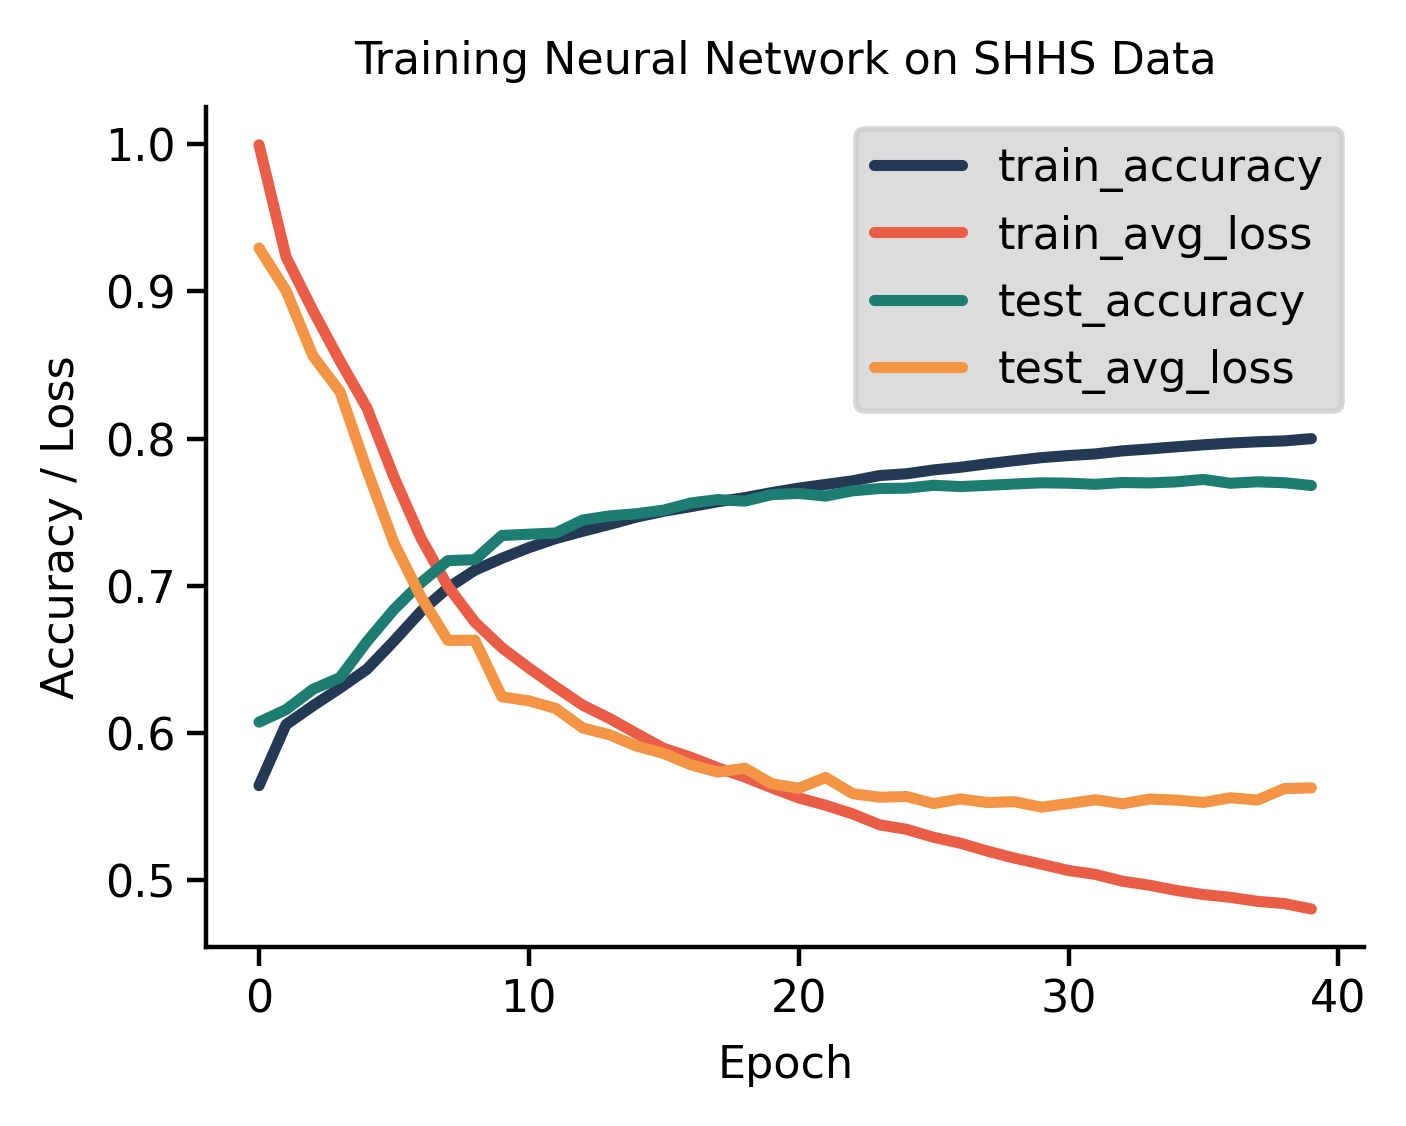

In [14]:
plot_accuracy_per_epoch(
    paths_to_pkl_files = [model_directory_path + loss_per_epoch_shhs_file],
    result_keys = ["train_accuracy", "train_avg_loss", "test_accuracy", "test_avg_loss"],
    label = ["train_accuracy", "train_avg_loss", "test_accuracy", "test_avg_loss"],
    title = "Training Neural Network on SHHS Data",
    xlabel = "Epoch",
    ylabel = "Accuracy / Loss",
)

Or one value for multiple files:

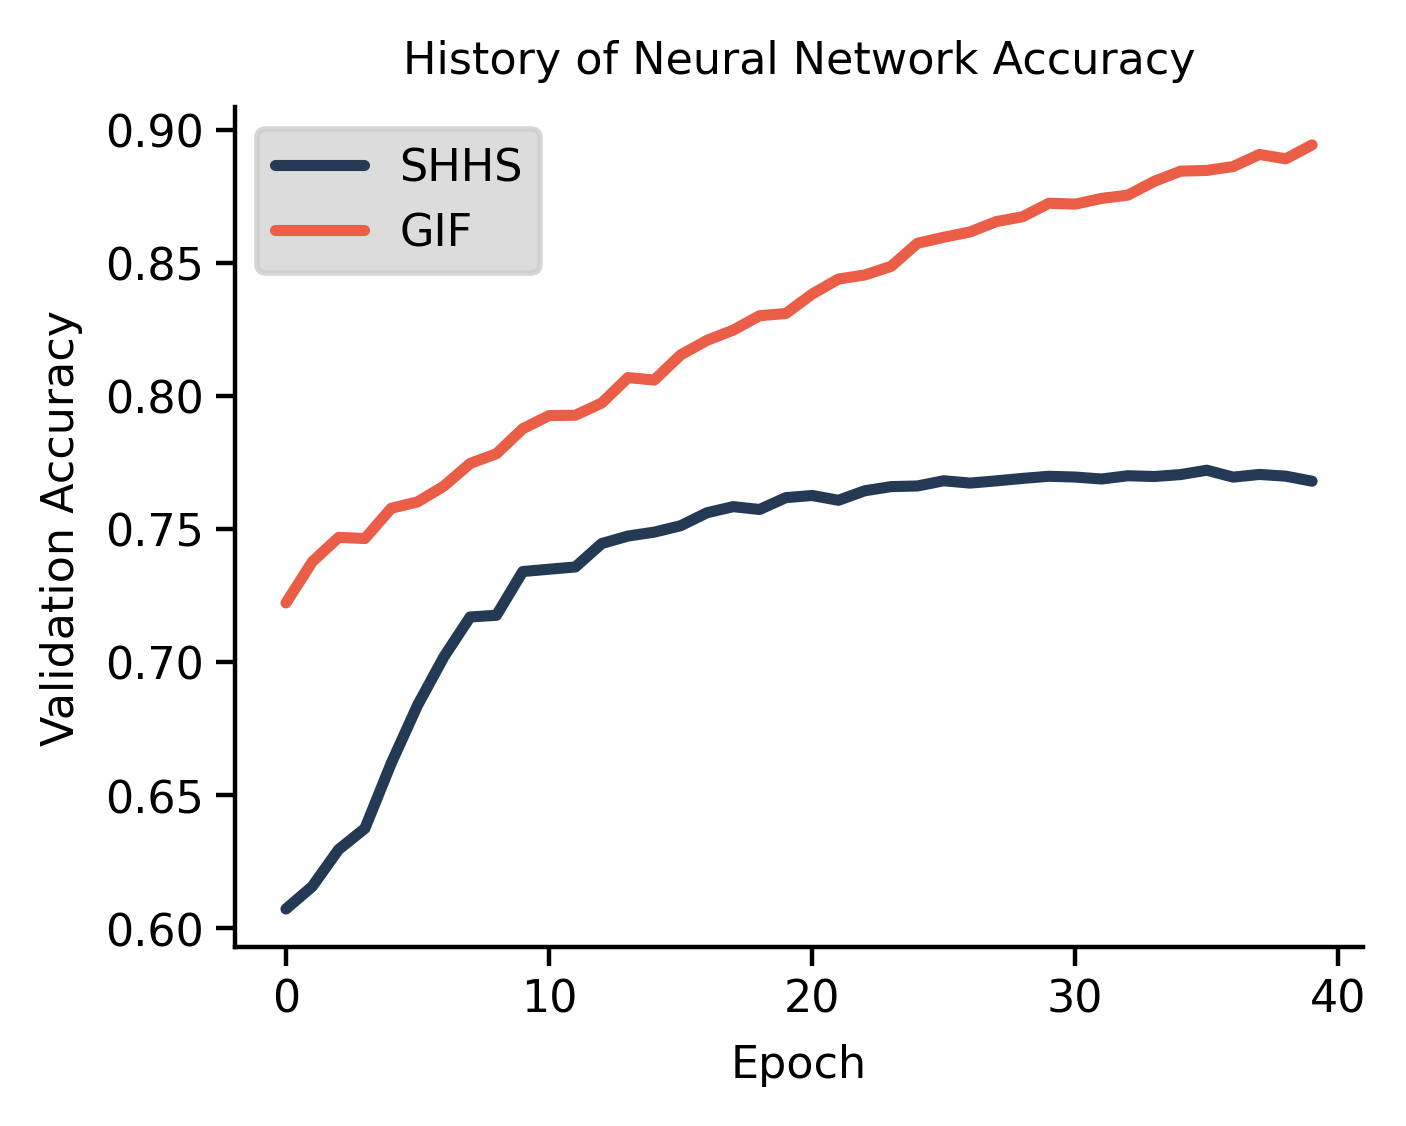

In [15]:
plot_accuracy_per_epoch(
    paths_to_pkl_files = [model_directory_path + loss_per_epoch_shhs_file, model_directory_path + loss_per_epoch_gif_file],
    result_keys = ["test_accuracy"],
    label = ["SHHS", "GIF"],
    title = "History of Neural Network Accuracy",
    xlabel = "Epoch",
    ylabel = "Validation Accuracy",
)

### Plotting Distribution of Performance Values

Some performance values return values for every sleep stage. In those cases, we can only plot the distribution
of one file. Otherwise we can use multiple:

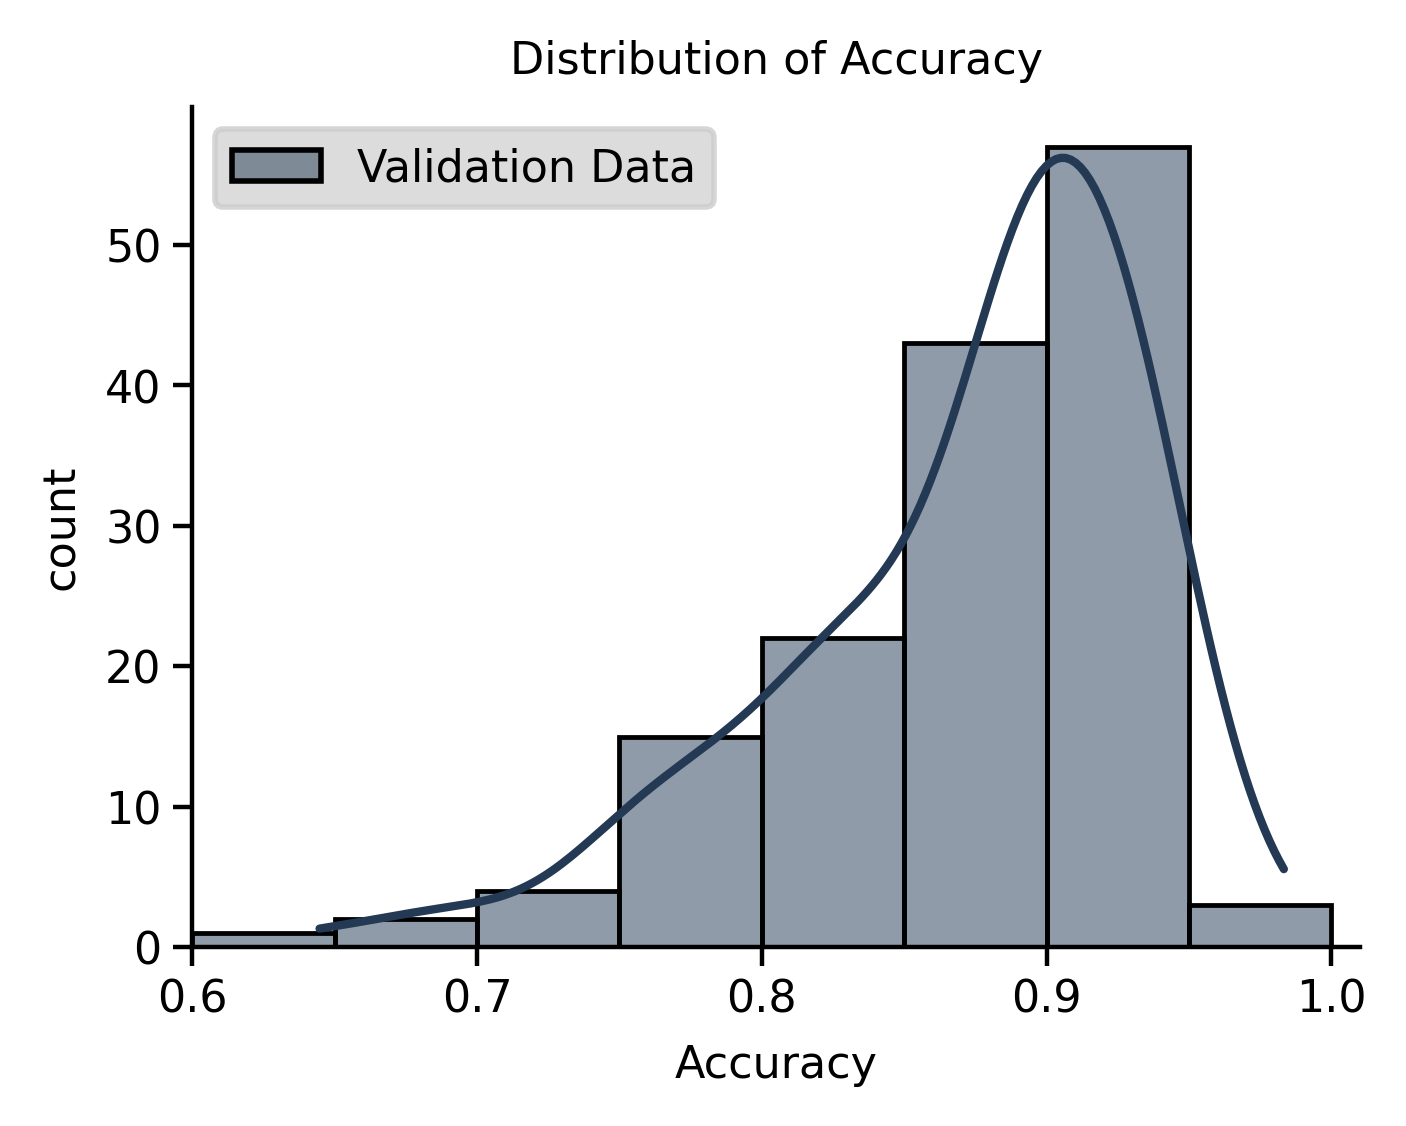

In [18]:
plot_distribution_of_score(
    paths_to_pkl_files = [validation_pid_results_path],
    path_to_project_configuration = model_directory_path + project_configuration_file,
    prediction_result_key = "Predicted",
    actual_result_key = "Actual",
    score_function = metrics.accuracy_score, # metrics.cohen_kappa_score
    combine_file_predictions = False,
    title = "Distribution of Accuracy",
    xlabel = "Accuracy",
    label = ["Validation Data"],
    binrange = (0, 1),
    binwidth = 0.05,
    xlim = (0.6, 1.01),
)

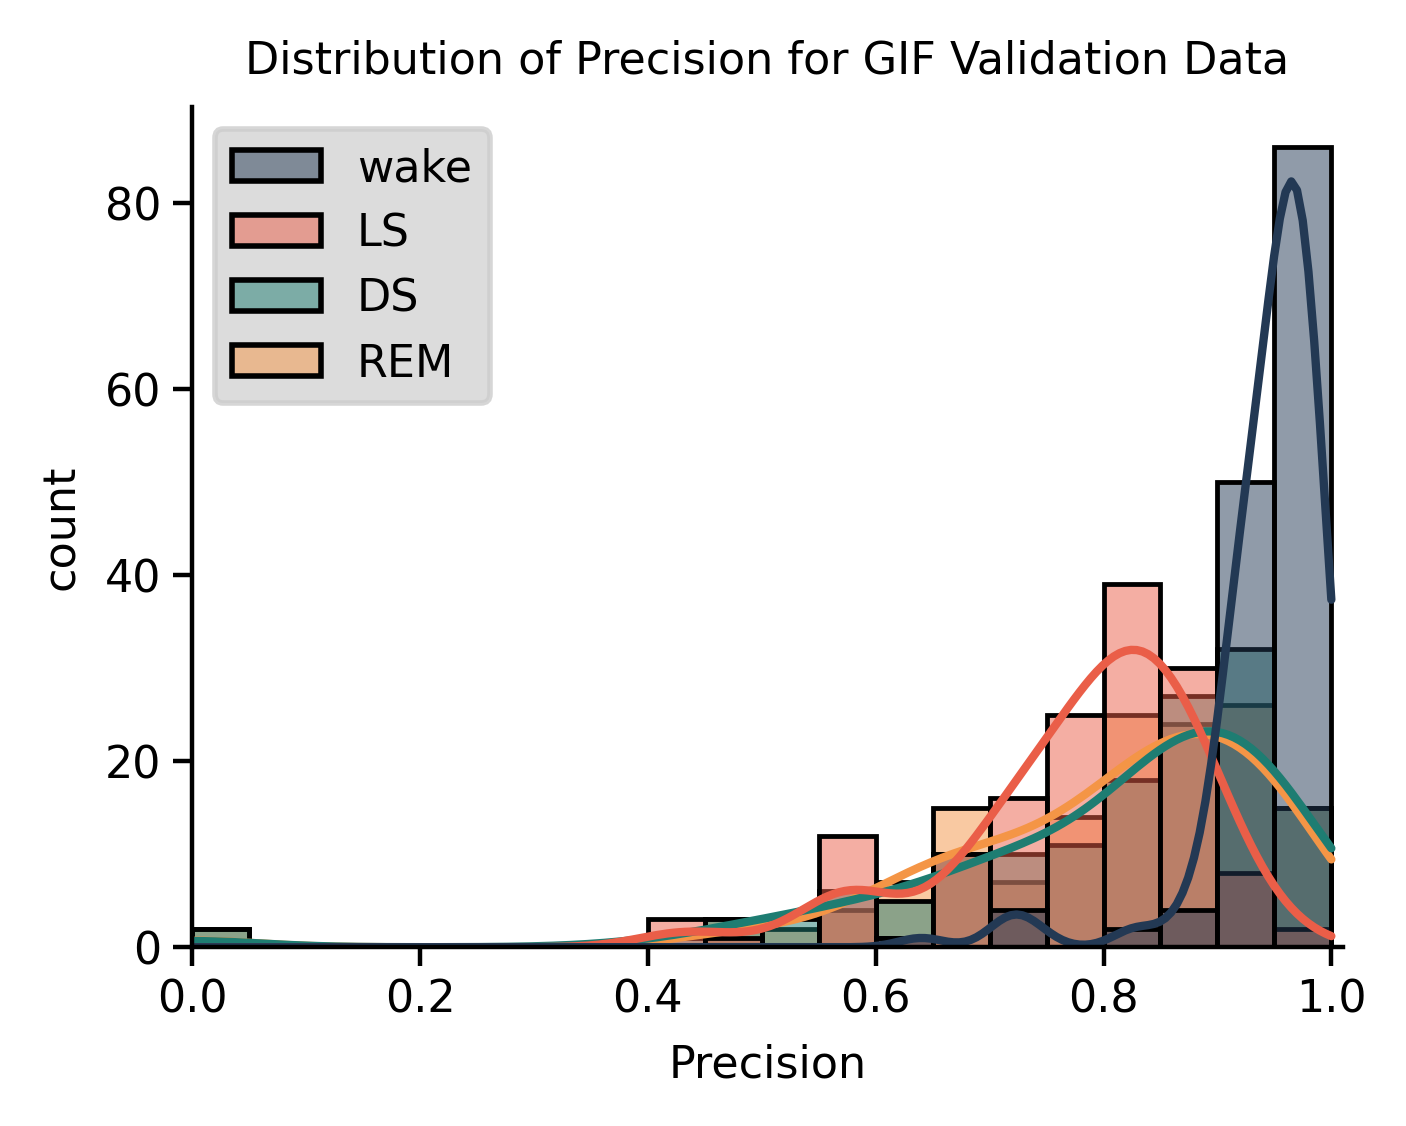

In [21]:
plot_distribution_of_score(
    paths_to_pkl_files = [validation_pid_results_path],
    path_to_project_configuration = model_directory_path + project_configuration_file,
    prediction_result_key = "Predicted",
    actual_result_key = "Actual",
    score_function = metrics.precision_score, # metrics.f1_score
    additional_score_function_args = {"average": None, "zero_division": np.nan},
    title = "Distribution of Precision for GIF Validation Data",
    xlabel = "Precision",
    label = ["Wake", "LS", "DS", "REM"],
    binrange = (0, 1),
    binwidth = 0.05,
    xlim = (0.0, 1.01),
)

Recall would also return one value for every sleep stage by default. However, if we change the 'average'
argument to something other than 'None', it returns only one value and you could therefore plot it for
multiple files at once. Note that this also works for the other performance functions with similar behaviour.

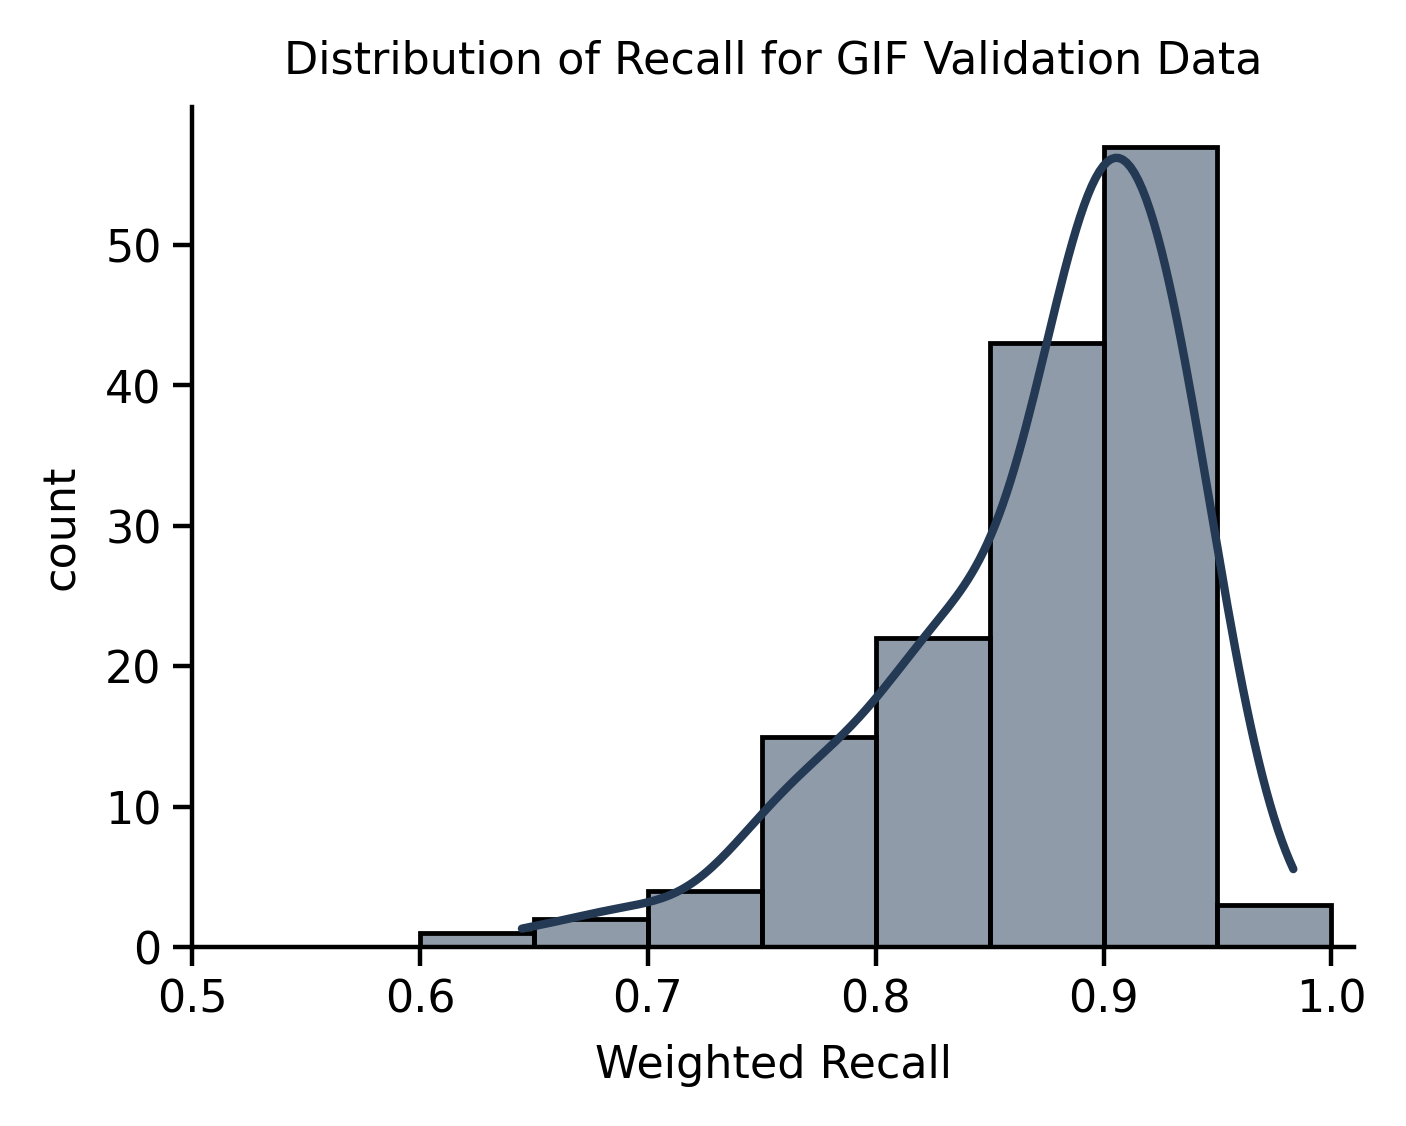

In [22]:
plot_distribution_of_score(
    paths_to_pkl_files = [validation_pid_results_path],
    path_to_project_configuration = model_directory_path + project_configuration_file,
    prediction_result_key = "Predicted",
    actual_result_key = "Actual",
    score_function = metrics.recall_score, # metrics.f1_score
    additional_score_function_args = {"average": 'weighted', "zero_division": np.nan},
    title = "Distribution of Recall for GIF Validation Data",
    xlabel = "Weighted Recall",
    binrange = (0, 1),
    binwidth = 0.05,
    xlim = (0.5, 1.01),
)

### Plotting Confusion Matrix

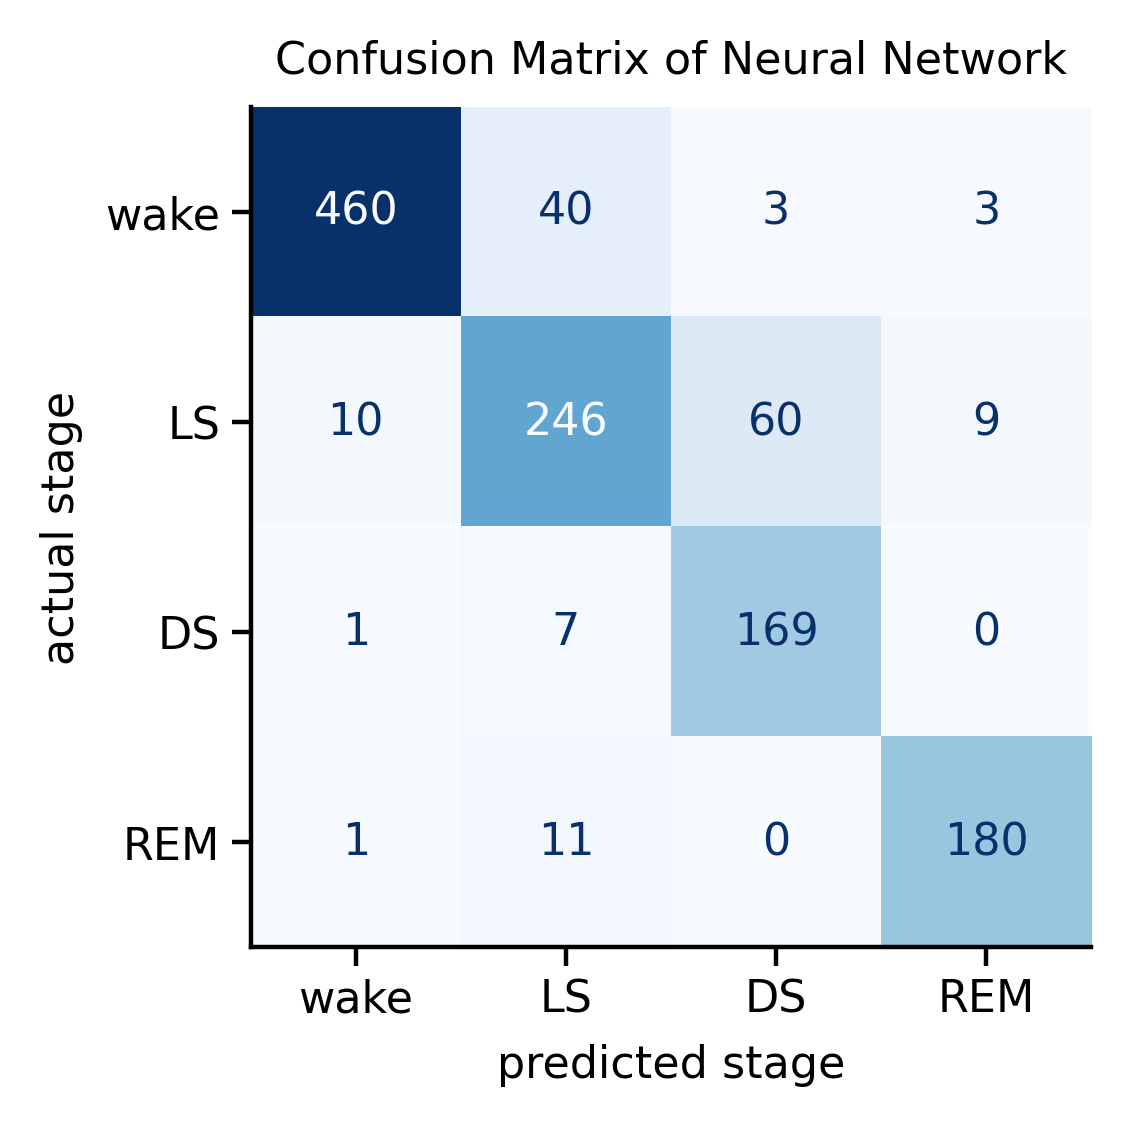

In [23]:
plot_confusion_matrix(
    path_to_pkl_file = validation_pid_results_path,
    path_to_project_configuration = model_directory_path + project_configuration_file,
    prediction_result_key = "Predicted",
    actual_result_key = "Actual",
    title = "Confusion Matrix of Neural Network",
    xlabel = "predicted stage",
    ylabel = "actual stage",
    normalize = None, # 'true', 'pred', 'all'
    values_format = None, # 'd', 'f', '.1%'
)

### Plotting Course of Sleep Stage

Choosing random data position: 109
Accuracy: 0.9383333333333334, Kappa: 0.8079651223141068


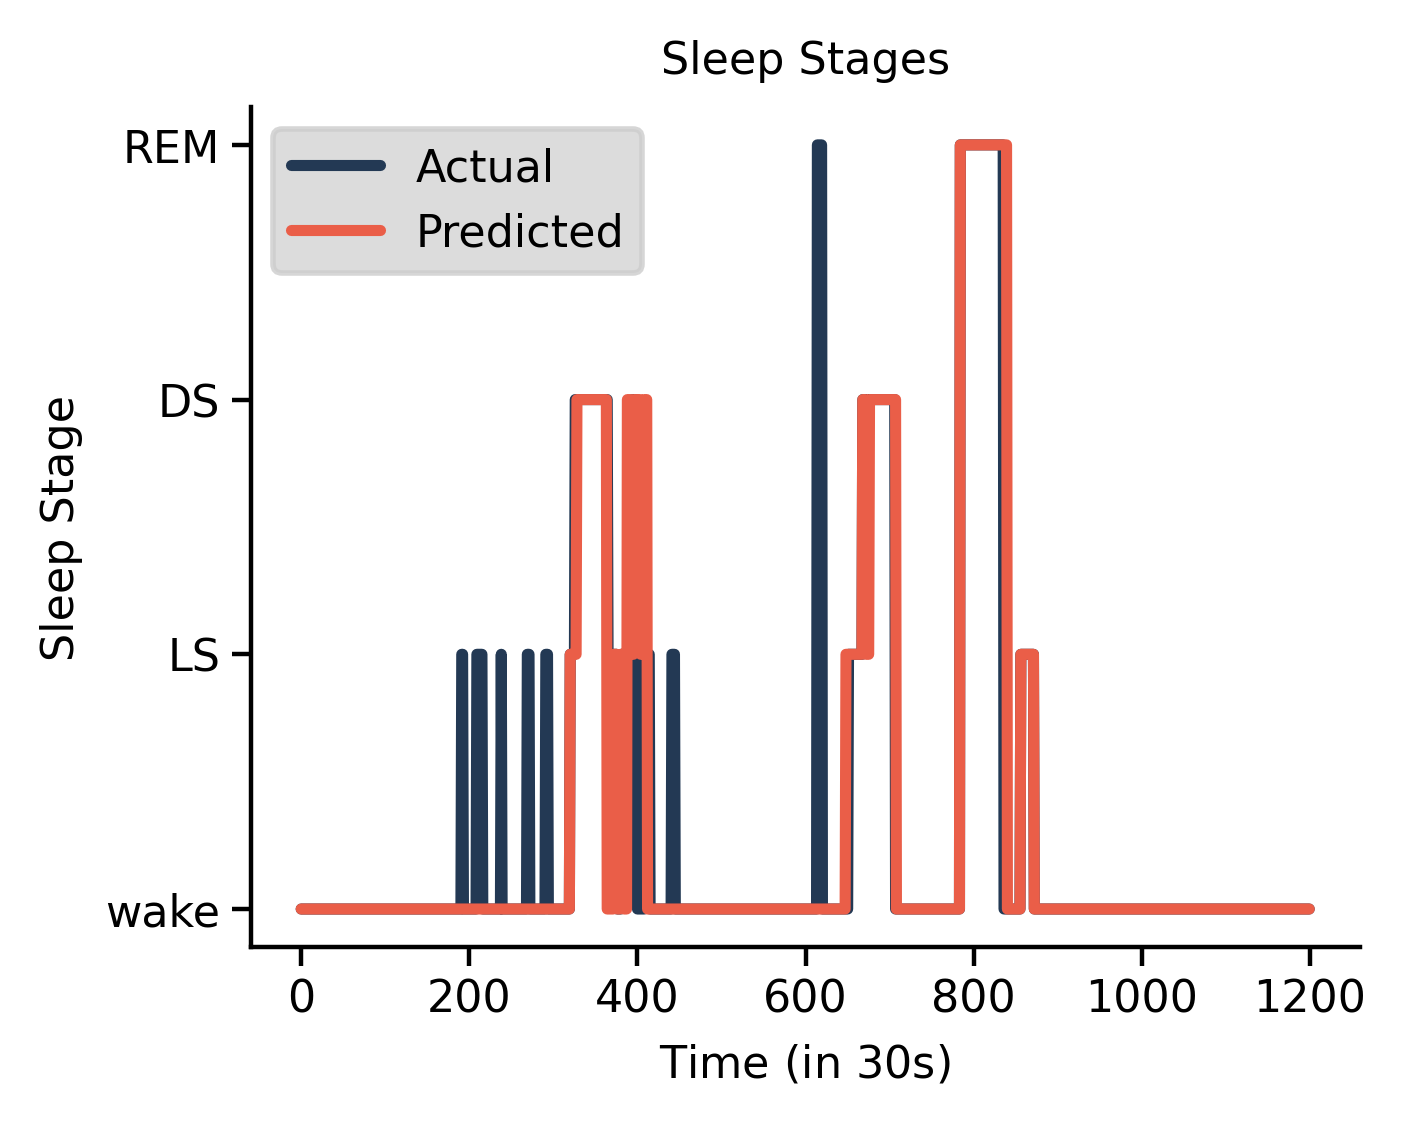

In [24]:
with open(model_directory_path + project_configuration_file, "rb") as f:
    project_configuration = pickle.load(f)

reciprocal_slp_frequency = round(1 / project_configuration['SLP_frequency'])

plot_actual_predicted(
    path_to_pkl_file = validation_pid_results_path,
    path_to_project_configuration = model_directory_path + project_configuration_file,
    prediction_result_key = "Predicted",
    actual_result_key = "Actual",
    data_position = None,
    title = "Sleep Stages",
    xlabel = r"Time $\left(\text{in } %i \text{s}\right)$" % reciprocal_slp_frequency,
    ylabel = "Sleep Stage",
)

# Predicting Sleep Stages

We already introduced how to predict the sleep stages of validation data in [Predicting Sleep Stages (of 
validation data)](#predicting-sleep-stages-(of-validation-data)).

Now we want to predict the sleep stages for unknown data, utilizing the same function: `main_model_predicting`
This time, the results will not be saved to a different .pkl file, but will be appended to the dictionaries of
our exisitng dataset managed by the `SleepDataManager` class. The format of the new entries is shown below.

ATTENTION: The data must be processed by the class `SleepDataManager` in order to be accessable.

See: `main_model_predicting` in `main.py`

In [ ]:
# new dictionary entries:
# {
#     "SLP_predicted_probability":
#         - shape: (windows_per_signal, number_sleep_stages) 
#         - probabilities for each sleep stage,
#     "SLP_predicted":
#         - shape: (windows_per_signal) 
#         - predicted sleep stage with highest probability,
# }

## Setting File Paths

First we set the paths to the data we want to predict the sleep stages for, as well as where this altered
will be saved:

In [ ]:
path_to_unknown_dataset = "/Volumes/NaKo-UniHalle/RRI_and_MAD/NAKO-33a.pkl"
path_to_processed_unknown_dataset = "Processed_NAKO/NAKO-33a.pkl"

First, we need to process the data using the `SleepDataManager` class:

In [25]:
Process_NAKO_Dataset(
    path_to_nako_dataset = path_to_unknown_dataset,
    path_to_save_processed_data = path_to_processed_unknown_dataset,
    path_to_project_configuration = model_directory_path + project_configuration_file,
)

All IDs are unique.

Preproccessing datapoints from NAKO dataset (ensuring uniformity):
   ✅: 100.0% [██████████████████████] 7365 / 7365 | 7m 51s / 7m 51s (0.1s/it) | 


Afterwards, we utilize the `main_model_predicting` function like demonstrated before:

In [ ]:
main_model_predicting(
    path_to_model_state = model_directory_path + model_state_after_shhs_gif_file,
    path_to_processed_data = path_to_processed_unknown_dataset,
    path_to_project_configuration = model_directory_path + project_configuration_file,
)

## Reversing Signal Split

After the predicted sleep stages were added to the database, we want to reverse the signal split that was 
applied to the data during the saving process. To do this, we will utilize the `SleepDataManager` class.

Calling the function below will produce a two-dimensional array for "SLP_predicted_probability" and "SLP_predicted" due to overlapping segments generating multiple predictions for the same time point.
- For "SLP_predicted_probability", the mean probability is calculated for each sleep stage across the overlapping predictions.
- For "SLP_predicted", all overlapping predictions for each time point are gathered into an array. Naturally, the number of data points per time point will vary.

In [ ]:
data_manager = SleepDataManager(file_path = path_to_processed_unknown_dataset)
data_manager.reverse_signal_split()

## Summarizing Predicted Sleep Stages

After reversing the signal split, some time points will have multiple prediction results.

As a result, \"SLP_predicted_probability\" and \"SLP_predicted\" may be less straightforward to interpret. 
While they offer more insight into prediction accuracy, we may prefer a consolidated list of the most 
reasonable predictions.

To achieve this, we simply load the results and pass them to the function: `summarize_predicted_signal`

In [ ]:
random_datapoint = data_manager.load(random.randint(0, len(data_manager) - 1))

slp_predicted_probability = random_datapoint["SLP_predicted_probability"] # type: ignore
slp_predicted = random_datapoint["SLP_predicted"] # type: ignore

slp_predicted_probability_summarized = summarize_predicted_signal(predicted_signal = slp_predicted_probability, mode = "probability")
slp_predicted_summarized = summarize_predicted_signal(predicted_signal = slp_predicted, mode = "majority")

message = "Original format of the data:"
print(message)
print("-" * len(message))

print("\n\"SLP_predicted_probability\"")
print(slp_predicted_probability[:3]) # type: ignore

print("\n\"SLP_predicted\"")
print(slp_predicted[:3]) # type: ignore

message = "\nSummarized format of the data:"
print(message)
print("-" * len(message))

print("\n\"SLP_predicted_probability\"")
print(slp_predicted_probability_summarized[:3])

print("\n\"SLP_predicted\"")
print(slp_predicted_summarized[:3])

# Tipp 10

In [7]:
import numpy as np
import random

a = ""
rand_old = ";"

for i in range(200):
    decision = random.randint(0, 10)

    if decision < 9:
        rand = random.randint(0, 12)
        if rand == 10:
            rand = "`"
        elif rand == 11:
            rand = "-"
        elif rand == 12:
            rand = "="
    elif decision > 9:
        rand = random.randint(0, 2)
        if rand == 0:
            rand = ","
        elif rand == 1:
            rand = "."
        elif rand == 2:
            rand = "/"
    
    if rand == rand_old:
        continue
    rand_old = rand
    
    a += str(rand) + " "

print(a)

9 3 8 9 . 1 0 3 9 8 2 = 7 . 7 - 3 . 5 = - 4 . ` 5 ` 3 = 9 / - 6 9 ` 0 1 8 0 2 5 7 . 7 1 8 4 = - . 6 - ` 2 0 / = 8 9 = 4 - 8 ` 9 5 = 5 = . / 6 . , / 3 7 5 3 / 4 8 0 1 2 8 4 0 / ` 6 , . 8 . 2 / 1 0 9 0 8 1 = 6 4 1 8 1 7 - 0 2 7 4 0 - 8 3 - 7 9 7 = 9 ` 6 0 2 / 9 7 9 - 9 - 2 / 3 4 = 6 ` 1 ` 6 7 0 6 7 = 3 . = 4 2 . 0 2 = ` 


In [11]:
import numpy as np

a = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
print(a[:, 1])

b = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
c = np.array([[0], [0], [0], [0]])

print(np.append(b, c, axis = 1))

[ 2  5  8 11]
[[ 1  2  3  0]
 [ 4  5  6  0]
 [ 7  8  9  0]
 [10 11 12  0]]


In [ ]:
from dataset_processing import *

print("Original signal:")
test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(test)
reshaped_test = reshape_signal_to_overlapping_windows(
    signal = test,
    target_frequency = 1,
    nn_signal_duration_seconds = 16,
    number_windows = 8,
    window_duration_seconds = 2,
    overlap_seconds = 0,
    signal_type = "feature"
    )
print("\nSignal reshaped to overlapping windows:")
print(reshaped_test)
reversed_test = reverse_signal_to_windows_reshape(
    signal_in_windows = reshaped_test, # type: ignore
    target_frequency = 1,
    original_signal_length = 10,
    number_windows = 8,
    window_duration_seconds = 2,
    overlap_seconds = 0
    )
print("\nSignal reshaped back to original:")
print(reversed_test)

Original signal:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Signal reshaped to overlapping windows:
[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [ 0  0]
 [ 0  0]
 [ 0  0]]

Signal reshaped back to original:
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [ ]:
from dataset_processing import *
list = []

for path in list:
    gen = load_from_pickle(path)

In [5]:
a = []
b = [4, 5, 6]

print(b.index(7))

a.extend(b)
print(a)

ValueError: 7 is not in list

In [7]:
import random
import copy

all_char = ["~", "!", "@", "#", "$", "%", "^", "&", "*", "(", ")", "_", "+"]
temp_chars = copy.deepcopy(all_char)
message = ""
last_char = ""
for i in range(1000):
    if len(temp_chars) == 0:
        temp_chars = copy.deepcopy(all_char)
    this_char = random.choice(temp_chars)
    temp_chars.remove(this_char)
    message += this_char + " "
    last_char = this_char
print(message)

! ) ~ + * _ # % ^ ( @ & $ @ ( # + ^ ) $ % ~ ! & _ * ^ + & ( ! % # @ ) $ * ~ _ ) @ # + $ ~ * ! ^ _ ( & % + * % ^ # $ ( _ ! ~ @ & ) $ ! ~ % @ _ ) # & * + ^ ( ( ) * # _ ^ ~ % ! & + $ @ + ( $ ~ ) * _ @ # ! % & ^ & ^ @ % ( # ~ + ) _ ! * $ ( @ $ ~ ^ % ) ! & + # * _ # ^ * ~ $ _ ) + & ( @ ! % % ) & ^ ( ! $ @ ~ * # + _ ! % $ & _ ~ ^ @ ( * ) + # ~ & _ # $ * + ! ^ @ ( % ) + $ _ ! ^ * ~ & % ( # @ ) & $ ( # _ ) + ! * ^ ~ % @ ! * _ $ ) ^ ( & % @ + ~ # ! @ * $ # ) % _ ( + ~ ^ & % @ # & ~ _ ! ( + ) $ * ^ ! _ $ ~ ) & # ( + ^ * % @ ) + ~ & $ * ( # _ @ % ! ^ @ ^ + ! # _ % ( ) * $ & ~ & ~ + _ ^ * % ! # $ ( ) @ $ # & ( ~ @ ^ * ! + ) _ % + ) # $ ( & _ % * ! @ ~ ^ ^ ) $ * + & ( ! @ # ~ % _ + @ ! & # * ) ( $ _ ^ % ~ * ) ( % ! _ @ # & $ ^ + ~ _ ( ! ) % $ & + ^ @ ~ * # ) ^ $ @ ( _ ~ * & ! # + % $ @ ( # _ % ~ ! ) ^ * & + ( $ ! ~ ) & % ^ @ _ * + # + & ^ _ @ ( ) $ ! % * ~ # ^ $ @ ~ ! # ( % + ) * & _ ( * % & # ! ~ _ $ + ) @ ^ ! & + $ ~ ^ % _ # @ * ) ( + * @ ~ ( ^ & $ ) % ! # _ $ * @ _ # + ~ ) ^ ( % ! & ! # % _ @ + 